### **Motorway Clustering**

This is the shorter version of `motorway_clustering.ipynb` file.

In this we dive directly into clustering. 

This can be used after merged files of Trip Detail and AOS have already been created. 

In [1]:
%%capture
import pandas as pd
# import modin.pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
# import vaex # https://vaex.io/docs/index.html
import pathlib
from pathlib import *
import os
import pickle
# import cufflinks as cf
# import chart_studio.plotly as py
import seaborn as sns
import plotly.express as px
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot

init_notebook_mode(connected=True)
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from shapely.geometry import Point, Polygon

In [2]:
##TODO -> Create functions for repetitive tasks

# ,skiprows=range(3, 260000000)
# Input the csv
# Extracting a subset of 1000000 rows by default
def load_data(dir_name,base_filename):
    complete_path=os.path.join(dir_name, base_filename + "." + "csv")
    df=pd.read_csv(complete_path)
#     df = pd.concat((chunk for chunk in pd.read_csv(complete_path,sep=';',nrows=5000000,encoding= 'unicode_escape',engine='c',infer_datetime_format=True,chunksize=1000000,low_memory=False,usecols=['Numberplate','Latitude',
    #                                                                                                                           'Longitude','Meters_travelled','Time_elapsed','Point_speed','Number_of_lanes',
    #                                                                                                                           'Road_type','Road_class','Speed_restriction','TNO_Time-stamp'])))
    
#     df = pd.concat((chunk for chunk in pd.read_csv(complete_path,sep=';',nrows=20000000,encoding= 'unicode_escape',engine='c',infer_datetime_format=True,chunksize=1000000,low_memory=False)))
    return df

# Dropping the first and last row of csv ("------")
def drop_first_row(df):
    df=df.iloc[1:]
    df=df[:-1]
    return df

def resetIndex(df):
    return df.reset_index()


##TODO -> Rewrite this function

def cast_to_correct_dtype(df):
    
    if 'Id' in df.columns:
        df['Id'] = df['Id'].astype('int')
        
    if 'AOS_position_Id' in df.columns:
        df['AOS_position_Id'] = df['AOS_position_Id'].astype('int')
    
    if 'Acceleration_x' in df.columns:
        df['Acceleration_x'] = df['Acceleration_x'].astype('float')
        
    if 'Acceleration_y' in df.columns:
        df['Acceleration_y'] = df['Acceleration_y'].astype('float')
        
    if 'TNO_Valid' in df.columns:
        df['TNO_Valid'] = df['TNO_Valid'].astype('int')
    
    if 'Latitude' in df.columns:
        df['Latitude'] = df['Latitude'].astype('float')
        
    if 'Longitude' in df.columns:
        df['Longitude'] = df['Longitude'].astype('float')
        
    if 'Event/action_speed' in df.columns:
        df['Event/action_speed'] = df['Event/action_speed'].astype('int')
        
    if 'Event/action_type' in df.columns:
        df['Event/action_type'] = df['Event/action_type'].astype('int')    
        
    if 'Number_of_lanes' in df.columns:
        df['Number_of_lanes'] = df['Number_of_lanes'].astype('int')
        
    if 'Road_class' in df.columns:
        df['Road_class'] = df['Road_class'].astype('int')
        
    if 'Road_type' in df.columns:
        df['Road_type'] = df['Road_type'].astype('int')
        
    if 'Crash_position_Id' in df.columns:
        df['Crash_position_Id']=df['Crash_position_Id'].astype('int')
        
    if 'Crash_position_Id' in df.columns:
        df['Crash_position_Id'] = df['Crash_position_Id'].astype('int')
        
    if 'Point_speed' in df.columns:
        df['Point_speed'] = df['Point_speed'].astype('float')
        
    if 'Average_speed_fpp' in df.columns:
        df['Average_speed_fpp'] = df['Average_speed_fpp'].astype('float')  
        
    if 'Average_Speed' in df.columns:
        df['Average_Speed'] = df['Average_Speed'].astype('float')        

    if 'Maximum_speed' in df.columns:
        df['Maximum_speed'] = df['Maximum_speed'].astype('float')     
        
    if 'Meters_travelled' in df.columns:
        df['Meters_travelled'] = df['Meters_travelled'].astype('int')  

    if 'Road_form' in df.columns:
        df['Road_form'] = df['Road_form'].astype('int') 
        
    if 'Speed_restriction' in df.columns:
        df['Speed_restriction'] = df['Speed_restriction'].astype('int') 
        
    if 'Crash_speed' in df.columns:
        df['Crash_speed'] = df['Crash_speed'].astype('int')
        
    if 'Maximum_acceleration' in df.columns:
        df['Maximum_acceleration'] = df['Maximum_acceleration'].astype('float')
        
    if 'Numberplate' in df.columns:
        df['Numberplate']=df['Numberplate'].astype('str')
        

    return df

            

## Handling date time related fields

def cast_date_time(df):
    if 'AOS_event/action_time' in df.columns:
        df['AOS_event/action_time']=pd.datetime(df['AOS_event/action_time'],errors='coerce')
        df['AOS_event/action_time_hour']=df['AOS_event/action_time'].dt.hour
    
    if 'TNO_Trip-start' in df.columns:
        df['TNO_Trip-start'] = pd.to_datetime(df['TNO_Trip-start'],errors='coerce')
        df['TNO_Trip-start_hour'] = df['TNO_Trip-start'].dt.hour
        
    if 'TNO_Trip-end' in df.columns:
        df['TNO_Trip-end'] = pd.to_datetime(df['TNO_Trip-end'],errors='coerce')
        
    if 'Position_time' in df.columns:
        df['Position_time'] = pd.to_datetime(df['Position_time'],errors='coerce')

    if 'TNO_Time-stamp' in df.columns:
        df['TNO_Time-stamp'] = pd.to_datetime(df['TNO_Time-stamp'],errors='coerce')
        df['TNO_Time-stamp_hour'] = df['TNO_Time-stamp'].dt.hour
        
    return df

## Converting Time Stamps to datetime

def date_and_time_columns(df):
    if 'AOS_event/action_time' in df.columns:
        df['AOS Trip Date']=df['AOS_event/action_time'].dt.date
        df['AOS Event Time']=df['AOS_event/action_time'].dt.time
        df['AOS Trip Hour']=df['AOS_event/action_time'].dt.hour
    
    
    if 'TNO_Time-stamp' in df.columns:
        df['TNO Trip Date'] = df['TNO_Time-stamp'].dt.date
        df['TNO Trip Time'] = df['TNO_Time-stamp'].dt.time
        df['TNO Trip Hour']=df['TNO_Time-stamp'].dt.hour
        # df['TNO Trip Hour'] = df['TNO Trip Time'].dt.hour
    return df

def Time_of_the_day(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x < 12 ):
        return 'Morning'
    elif (x >= 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'
    
    
def rename_some_stuff(df):
    if 'Event/action_type' in df.columns:
        df["Event type Rename"]=df["Event/action_type"].replace({0: 'Headway Warning = OFF', 1: 'Headway Warning (long)', 2: 'Headway Warning (medium)'
                                                                                 ,3: 'Headway Warning (short)',10:'Lane Departure Warning = OFF',11:'Left Lane Departure Warning = ON'
                                                                                 ,12:'Right Lane Departure Warning = ON',13:'Left and Right Lane Departure Warning = ON'
                                                                                 ,20:' Indicators = OFF',21:'Left Indicator = ON',22:'Right Indicator = ON',23:'Left and Right Indicator = ON'
                                                                                 ,40:'Brakes = OFF',41:'Brakes = ON'})
        
    if 'Road_type' in df.columns:
        df["Road_type_Rename"]=df["Road_type"].replace({0: "Urban", 1: "Motorway",2:"Extra Urban",3:"Unavailable"})
        
    return df

def detect_overspeeding_count(df):
    # create a list of our conditions
#     if 'Event/action_speed' and 'Speed_restriction' in df.columns:
#         conditions = [(df['Event/action_speed']> df['Speed_restriction'])]
#         # # create a list of the values we want to assign for each condition
#         values = [1]
#         # create a new column and use np.select to assign values to it using our lists as arguments
#         df['Overspeeding_event'] = np.select(conditions, values)
        
    # return df

    if 'Point_speed' and 'Speed_restriction' in df.columns:
        conditions = [(df['Point_speed']> df['Speed_restriction'])]
        # # create a list of the values we want to assign for each condition
        values = [1]
        # create a new column and use np.select to assign values to it using our lists as arguments
        df['Overspeeding_event'] = np.select(conditions, values)
        
    return df

def some_processing(df):
    if 'Meters_travelled' in df.columns:
        df['KmTravelled']=df['Meters_travelled']/1000
    return df

**Select Motorway to Explore**

Utrecht-Eindhoven Highway

In [3]:
df_grp_aos_trip_detail_ue_highway=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering Motorway\df_grp_aos_trip_detail_utrecht_eindhoven_highway.csv")
df_grp_aos_trip_detail_ue_highway_complete=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering Motorway\df_grp_aos_trip_detail_complete_utrecht_eindhoven_highway.csv")
# city_name='Amsterdam'
location="Utrecht-Eindhoven Highway (M2)"
location1="across motorways in the NL"

Utrecht-Leek Highway

In [4]:
# df_grp_aos_trip_detail_ul_highway=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering Motorway\df_grp_aos_trip_detail_utrecht_leek_highway.csv")
# df_grp_aos_trip_detail_ul_highway_complete=pd.read_csv(r"D:\AOS FOT\Octo\CSV Export\Individual Clustering Motorway\df_grp_aos_trip_detail_complete_utrecht_leek_highway.csv")
# location="Utrecht-Leek Highway (M1)"
# location1="across motorways in the NL"

## **Correlation Plots**

In [5]:
def select_feature_to_examine(feature):
    if feature=="Normalized Level I-HW":
        feature_name="Norm HW-L(I) "
    
    elif feature=='Normalized Level II-HW':
        feature_name="Norm HW-L(II) "

    elif feature=='Normalized Level III-HW':
        feature_name="Norm HW-L(III) "
        
    elif feature=='Mean Point Speed (km/h)':
        feature_name="Mean Point Speed "
        
    elif feature=='Normalized L-LDW':
        feature_name="Norm L-LDW "
        
    elif feature=='Normalized R-LDW':
        feature_name="Norm R-LDW "
        
    elif feature=='Normalized Braking Events':
        feature_name="Norm Braking Events "
        
    return feature,feature_name

"""Uncomment feature to be examined"""

# feature,feature_name=select_feature_to_examine('Mean Point Speed (km/h)')
# feature,feature_name=select_feature_to_examine('Normalized Braking Events')
# feature,feature_name=select_feature_to_examine('Normalized Level I-HW')
# feature,feature_name=select_feature_to_examine('Normalized Level II-HW')
# feature,feature_name=select_feature_to_examine('Normalized Level III-HW')
# feature,feature_name=select_feature_to_examine('Normalized L-LDW')
feature,feature_name=select_feature_to_examine('Normalized R-LDW')

In [6]:
def merge_dfs(df1,df2):
    df_outer = pd.merge(df1, df2, on='Numberplate', how='inner') #here Numberplate is common column
    return df_outer

df_outer=merge_dfs(df_grp_aos_trip_detail_ue_highway,df_grp_aos_trip_detail_ue_highway_complete)
# df_outer=merge_dfs(df_grp_aos_trip_detail_ul_highway,df_grp_aos_trip_detail_ul_highway_complete)
# df_outer

In [7]:
def drop_data(df):
    df = df.drop(df[df['Normalized Braking Events_x']>4].index)
    df = df.drop(df[df['Normalized Level I-HW_x']>3].index)
    df = df.drop(df[df['Normalized Braking Events_y']>4].index)
    df = df.drop(df[df['Normalized Level I-HW_y']>3].index)
    return df

df_outer=drop_data(df_outer)

In [8]:
df_outer.rename(columns={'Mean Point Speed (km/h)_x': 'Mean Point Speed on '+location,
                         'Mean Point Speed (km/h)_y': 'Mean Point Speed '+location1,
                         'Normalized Braking Events_x': 'Norm Braking Events on '+location,
                         'Normalized Braking Events_y': 'Norm Braking Events '+location1,
                         'Normalized Level I-HW_x': 'Norm HW-L(I) on '+location,
                         'Normalized Level I-HW_y': 'Norm HW-L(I) '+location1,
                         'Normalized Level II-HW_x': 'Norm HW-L(II) on '+location,
                         'Normalized Level II-HW_y': 'Norm HW-L(II) '+location1,
                         'Normalized Level III-HW_x': 'Norm HW-L(III) on '+location,
                         'Normalized Level III-HW_y': 'Norm HW-L(III) '+location1,
                         'Normalized R-LDW_x': 'Norm R-LDW on '+location,
                         'Normalized R-LDW_y': 'Norm R-LDW '+location1,
                         'Normalized L-LDW_x': 'Norm L-LDW on '+location,
                         'Normalized L-LDW_y': 'Norm L-LDW '+location1
                         },
          inplace=True, errors='raise')

In [9]:
df_outer

,Unnamed: 0_x,Numberplate,Latitude_x,Longitude_x,Mean Point Speed on Utrecht-Eindhoven Highway (M2),Distance Covered (km)_x,Norm Braking Events on Utrecht-Eindhoven Highway (M2),Norm HW-L(I) on Utrecht-Eindhoven Highway (M2),Norm HW-L(II) on Utrecht-Eindhoven Highway (M2),Norm HW-L(III) on Utrecht-Eindhoven Highway (M2),...,Longitude_y,Mean Point Speed across motorways in the NL,Distance Covered (km)_y,Norm Braking Events across motorways in the NL,Norm HW-L(I) across motorways in the NL,Norm HW-L(II) across motorways in the NL,Norm HW-L(III) across motorways in the NL,Norm L-LDW across motorways in the NL,Norm R-LDW across motorways in the NL,Motorway_y
0,1,BLFR75,51.677114,5.307045,81.454545,55.774,0.0,2.277047,0.645462,0.107577,...,4.855629,82.968989,13521.369,0.0,1.443271,0.348411,0.123212,0.031284,0.177127,Corresponding Trips (M2-NL)
1,2,BLLF65,51.738478,5.273557,81.125000,131.933,0.0,1.402227,0.394139,0.166751,...,5.202296,79.906177,4739.117,0.0,2.138162,0.495029,0.146019,0.035028,0.152138,Corresponding Trips (M2-NL)
2,3,BLLG10,51.766208,5.256579,80.463415,170.566,0.0,1.084624,0.269690,0.134845,...,5.321453,83.272860,9455.642,0.0,1.208168,0.342441,0.117919,0.132408,0.689324,Corresponding Trips (M2-NL)
3,4,BLLG74,51.780439,5.250781,81.285714,57.719,0.0,0.623711,0.398482,0.121277,...,5.290594,82.422666,14837.784,0.0,0.920960,0.233525,0.069957,0.110394,0.083436,Corresponding Trips (M2-NL)
4,5,BLLG77,51.723541,5.284974,79.851852,56.533,0.0,0.300709,0.088444,0.035378,...,5.502376,81.230589,7279.406,0.0,1.796163,0.463774,0.178998,0.101657,0.713795,Corresponding Trips (M2-NL)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,196,BVRZ72,51.784891,5.242902,80.550459,227.175,0.0,0.488610,0.189281,0.052823,...,5.014329,80.240547,5912.773,0.0,0.328272,0.085747,0.018096,0.009471,0.221216,Corresponding Trips (M2-NL)
151,197,BVSG72,51.743846,5.273260,78.932432,1270.593,0.0,0.647729,0.177083,0.014167,...,4.955267,80.367073,19372.259,0.0,0.314006,0.073714,0.011408,0.005265,0.276478,Corresponding Trips (M2-NL)
152,198,BVSR09,51.811581,5.248110,83.571429,57.553,0.0,0.764513,0.156378,0.052126,...,5.825521,83.461626,11127.258,0.0,0.242108,0.049338,0.016266,0.021569,0.148644,Corresponding Trips (M2-NL)
153,199,BVTF35,51.761242,5.267709,80.785714,57.668,0.0,2.236942,0.658944,0.260110,...,5.222242,80.089897,5104.617,0.0,0.405515,0.094033,0.031148,0.011558,0.512085,Corresponding Trips (M2-NL)


In [10]:
feature_x= feature_name+'on '+location
feature_y=feature_name+location1

<AxesSubplot:xlabel='Norm R-LDW on Utrecht-Eindhoven Highway (M2)', ylabel='Norm R-LDW across motorways in the NL'>

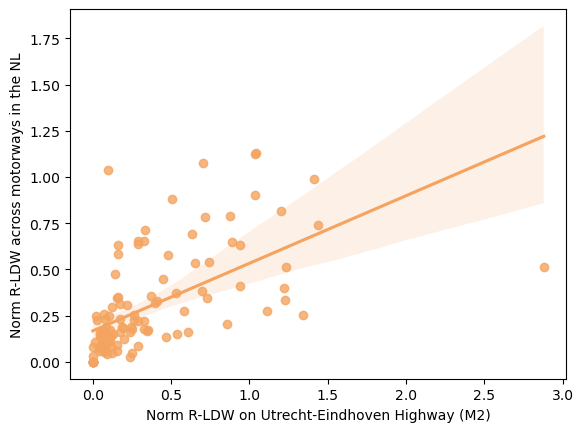

In [11]:
sns.regplot(data=df_outer,x=feature_x, y=feature_y,color="sandybrown")

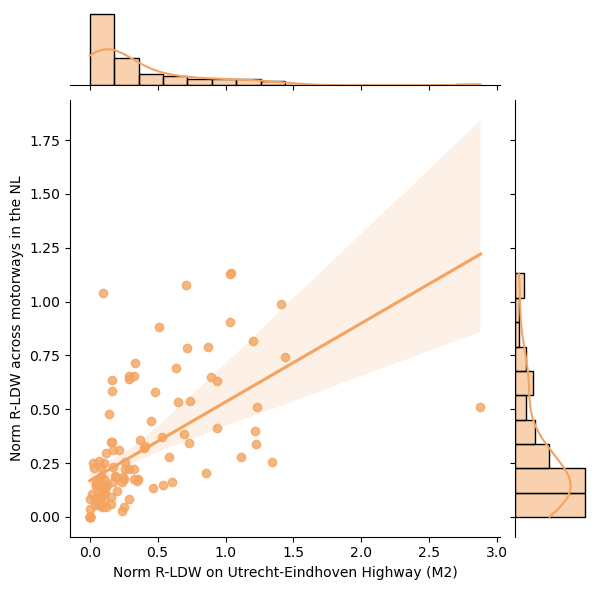

In [12]:
sns.jointplot(x=feature_x, y=feature_y, data=df_outer, kind="reg",palette="pastel",color="sandybrown")

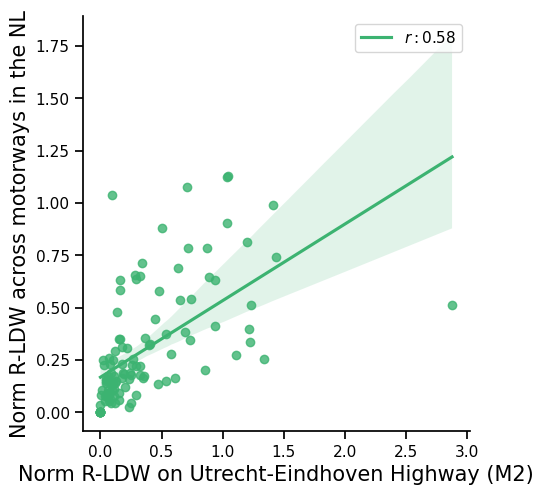

In [13]:
#  import pandas as pd 
#  import seaborn as sns
#  import matplotlib.pyplot as plt 
# import stats
from scipy import stats
# sns.set(rc = {'figure.figsize':(15,8)})
# from matplotlib import rcParams

# # figure size in inches
# rcParams['figure.figsize'] = 15,8


# feature_x="Mean Point Speed in "
# feature_y="Mean Point Speed "
# sns.set_style("ticks")
# df = pd.read_excel('data.xlsx')
# mediumseagreen
# cornflowerblue
sns.set_context("notebook")
p = sns.lmplot(x=feature_x, y=feature_y,
        data=df_outer,scatter_kws={"color": "mediumseagreen"},
        line_kws={'label':"Linear Reg","color":"mediumseagreen"}, legend=True)

ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
# assuming you computed r_squared which is the coefficient of determination somewhere else
slope, intercept, r_value, p_value, std_err = stats.linregress(df_outer[feature_x],df_outer[feature_y])
label_line_1 = r'$y={0:.1f}x+{1:.1f}'.format(slope,intercept)
label_line_2 = r'$r:{0:.2f}$'.format(r_value) # as an exampple or whatever you want[!
# L_labels[0].set_text(label_line_1)
L_labels[0].set_text(label_line_2)
plt.xlabel(feature_x,fontsize=15)
plt.ylabel(feature_y,fontsize=15)
# plt.title("Normalized Braking Events - Amsterdam & the NL (Urban Roads)")
plt.savefig(r"C:\Users\ivasu\Desktop\p1.png")

In [14]:
import scipy
from scipy import stats
scipy.stats.spearmanr(df_outer[feature_x], df_outer[feature_y])[0]

0.7461479977972815

### Plots

In [15]:
def grp_dfs_highway_highway_complete(df1,df2):
    df1.drop(['Unnamed: 0'], axis = 1, inplace = True) 
    df2.drop(['Unnamed: 0'], axis = 1, inplace = True) 
    df_grouped_cities=pd.concat([df1, df2])
    df_grouped_cities = df_grouped_cities.drop(df_grouped_cities[df_grouped_cities['Normalized Braking Events']>4].index)
    df_grouped_cities = df_grouped_cities.drop(df_grouped_cities[df_grouped_cities['Normalized Level I-HW']>3].index)
    
    return df_grouped_cities

df_grouped_cities=grp_dfs_highway_highway_complete(df_grp_aos_trip_detail_ue_highway,df_grp_aos_trip_detail_ue_highway_complete) #Utrecht-Eindhoven Highway
# df_grouped_cities=grp_dfs_highway_highway_complete(df_grp_aos_trip_detail_ul_highway,df_grp_aos_trip_detail_ul_highway_complete) #Utrecht-Leek Highway

Viz the distribution

In [16]:
# intialise data of lists.
data = {'Motorway':['Utrecht to Eindhoven', 'Utrecht to Leek'],
        'Vehicle Count':[112, 32]}
  
# Create DataFrame
df = pd.DataFrame(data)
  
# Print the output.
df

,Motorway,Vehicle Count
0,Utrecht to Eindhoven,112
1,Utrecht to Leek,32


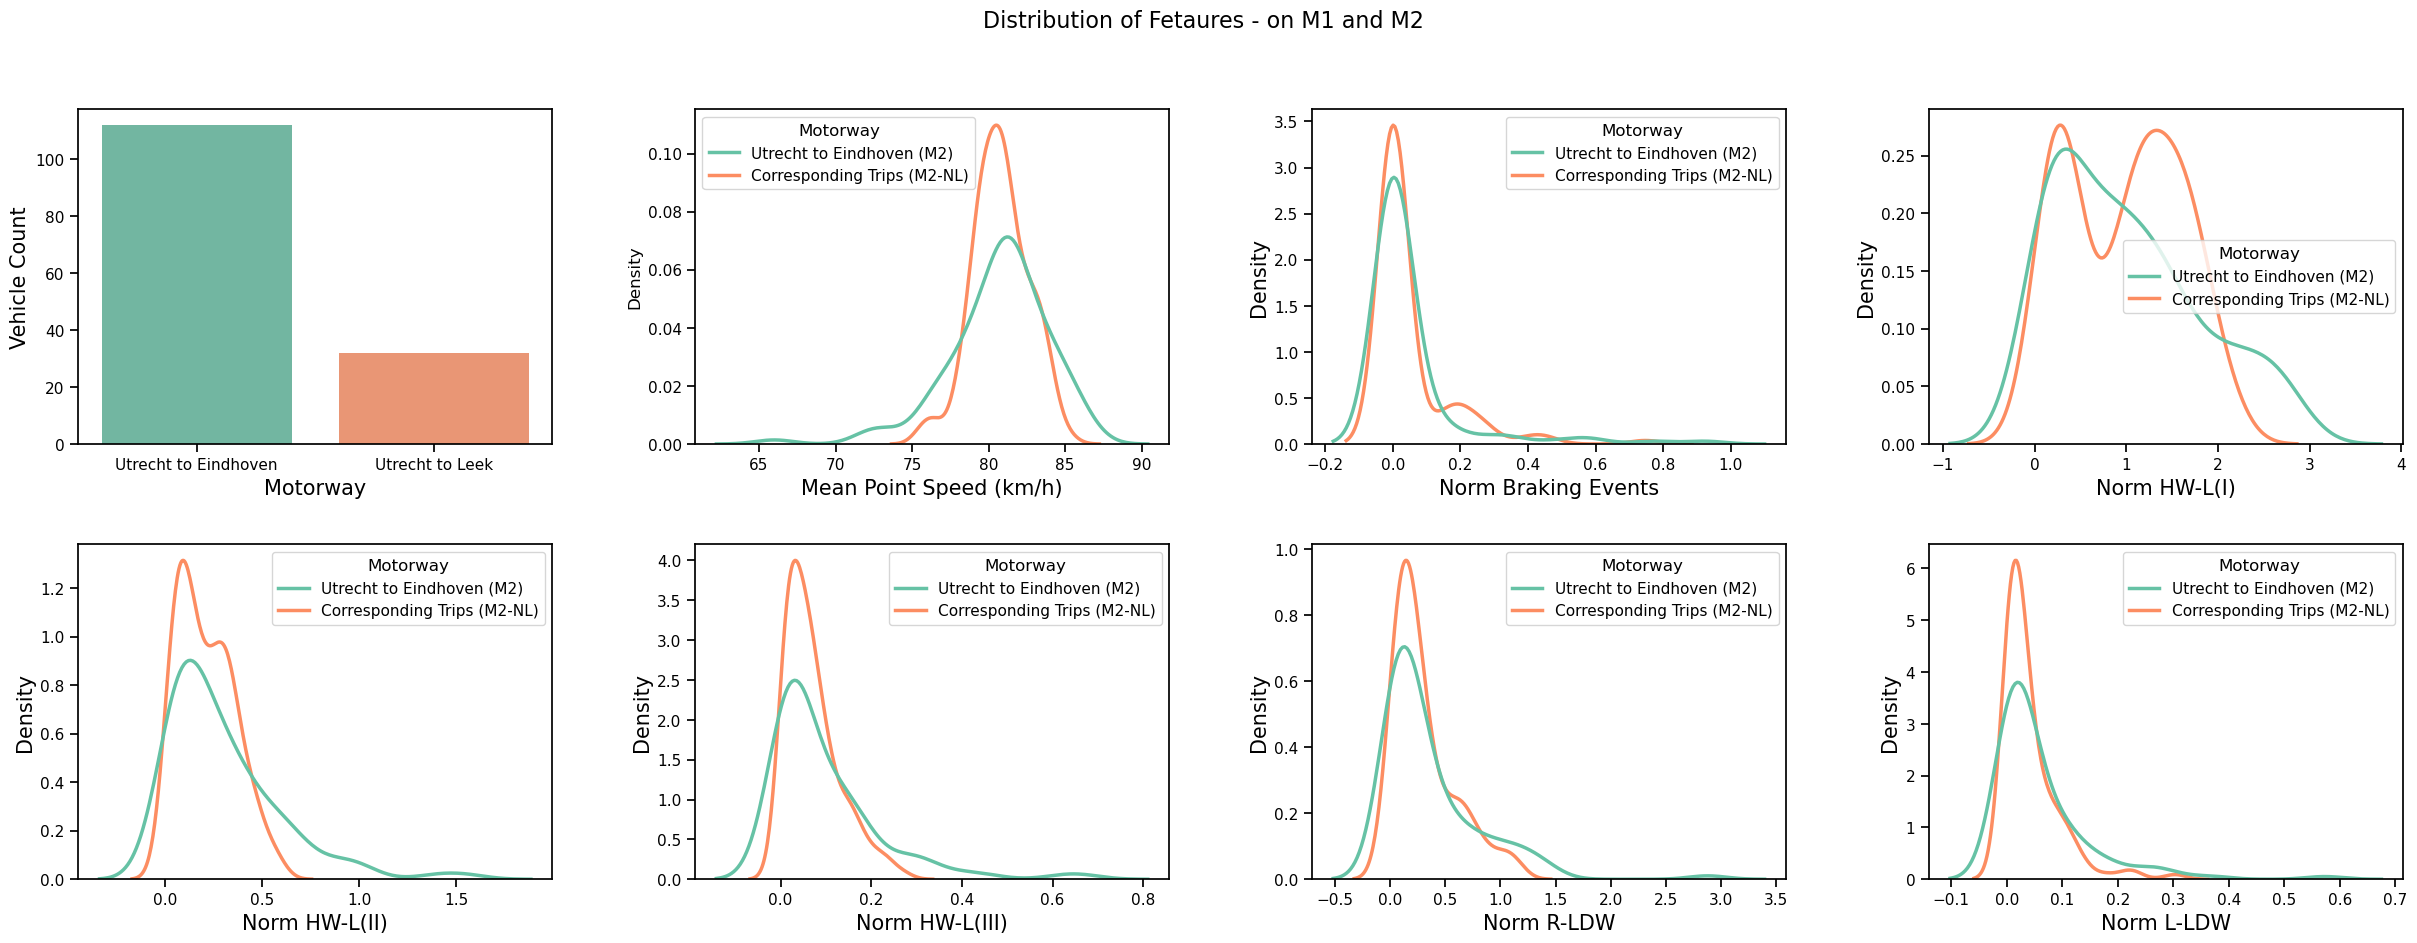

In [17]:
sns.set_context("notebook")
fig, axes = plt.subplots(2, 4, figsize=(30, 10))
# sns.set_context("notebook")
fig.suptitle('Distribution of Fetaures - on M1 and M2',fontsize=16)
# sns.set_context("notebook", font_scale=1.25)
sns.barplot(ax=axes[0,0],data=df,y="Vehicle Count",x="Motorway",palette="Set2")
axes[0,0].set_xlabel('Motorway',fontsize=15)
axes[0,0].set_ylabel('Vehicle Count',fontsize=15)

sns.kdeplot(ax=axes[0,1],data=df_grouped_cities,x="Mean Point Speed (km/h)",hue="Motorway",palette="Set2",linewidth=2.5)
axes[0,1].set_xlabel('Density',fontsize=15)
axes[0,1].set_xlabel('Mean Point Speed (km/h)',fontsize=15)

sns.kdeplot(ax=axes[0, 2], data=df_grouped_cities, x="Normalized Braking Events",linewidth=2.5,hue="Motorway",palette="Set2")
axes[0,2].set_ylabel('Density',fontsize=15)
axes[0,2].set_xlabel('Norm Braking Events',fontsize=15)

sns.kdeplot(ax=axes[0, 3], data=df_grouped_cities, x='Normalized Level I-HW',linewidth=2.5,hue="Motorway",palette="Set2")
axes[0,3].set_ylabel('Density',fontsize=15)
axes[0,3].set_xlabel('Norm HW-L(I)',fontsize=15)

sns.kdeplot(ax=axes[1, 0], data=df_grouped_cities, x='Normalized Level II-HW',linewidth=2.5,hue="Motorway",palette="Set2")
axes[1,0].set_ylabel('Density',fontsize=15)
axes[1,0].set_xlabel('Norm HW-L(II)',fontsize=15)

sns.kdeplot(ax=axes[1, 1], data=df_grouped_cities, x='Normalized Level III-HW',linewidth=2.5,hue="Motorway",palette="Set2")
axes[1,1].set_ylabel('Density',fontsize=15)
axes[1,1].set_xlabel('Norm HW-L(III)',fontsize=15)

sns.kdeplot(ax=axes[1,2], data=df_grouped_cities, x='Normalized R-LDW',linewidth=2.5,hue="Motorway",palette="Set2")
axes[1,2].set_ylabel('Density',fontsize=15)
axes[1,2].set_xlabel('Norm R-LDW',fontsize=15)

sns.kdeplot(ax=axes[1,3], data=df_grouped_cities, x='Normalized L-LDW',linewidth=2.5,hue="Motorway",palette="Set2")
axes[1,3].set_ylabel('Density',fontsize=15)
axes[1,3].set_xlabel('Norm L-LDW',fontsize=15)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3) #make the figure look better
# plt.savefig(r"C:\Users\ivasu\Desktop\figure.png")


In [18]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples, silhouette_score

Select Name of Route

In [19]:
# city_name="Utrecht to Eindhoven"
city_name="Utrecht to Leek"

In [20]:
%%capture
class Clustering:
    def __init__(self,feature,feature_name,df,increment,decrement):
        self.feature = feature
        self.feature_name = feature_name
        self.df=df
        self.increment =increment
        self.decrement =decrement
        
    def preprocess(self,df):
        """Preprocess data for KMeans clustering"""
    
        data = np.array(self.df[self.feature])
        data=data.reshape(-1, 1)
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
        
        return data
    
    
    def elbow_plot(self):
        """Create elbow plot from normalized data"""
        data=self.preprocess(self.df)
        sse = {}
        
        for k in range(2,11):
            kmeans = KMeans(n_clusters=k, random_state=1)
            kmeans.fit(data)
            sse[k] = kmeans.inertia_
        
        plt.title('Elbow plot for K selection'+"\n"+feature_name+'-'+ city_name)
        plt.xlabel('k')
        plt.ylabel('SSE')
        sns.pointplot(x=list(sse.keys()),y=list(sse.values()),color="sandybrown")
        plt.show()
        
        
    def silhouette_coeff(self):
        """Checking silhouette score"""
        data=self.preprocess(self.df)
        range_n_clusters = range(2,10)
        
        for n_clusters in range_n_clusters:
            clusterer = KMeans(n_clusters=n_clusters)
            preds = clusterer.fit_predict(data)
            centers = clusterer.cluster_centers_

            score = silhouette_score(data, preds)
            print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
            
            
    def find_k(self):
        """Find the optimum k clusters"""
        
        data=self.preprocess(self.df)
        sse = {}
        
        for k in range(2, 21):
            kmeans = KMeans(n_clusters=k, random_state=1)
            kmeans.fit(data)
            sse[k] = kmeans.inertia_
        
        kn = KneeLocator(x=list(sse.keys()), 
                    y=list(sse.values()), 
                    curve='convex', 
                    direction='decreasing')
        k = kn.knee + self.increment - self.decrement
        return k
    
    
    def run_kmeans(self):
        """Run KMeans clustering, including the preprocessing of the data
        and the automatic selection of the optimum k. 
        """

        data=self.preprocess(self.df)
        k = self.find_k()
        print(k)
        kmeans = KMeans(n_clusters=k,init='k-means++')
        x=kmeans.fit_predict(data)
        return self.df.assign(Clusters=kmeans.labels_)
    

clustering_kmeans = Clustering(feature,feature_name,df_grouped_cities,increment=0, decrement=2) # increase or decrease number of assigned clusters using `increment` or `decrement`
clustering_kmeans.elbow_plot() 
clustering_kmeans.silhouette_coeff()
Clusters=clustering_kmeans.run_kmeans()
Clusters
# df_grouped_cities

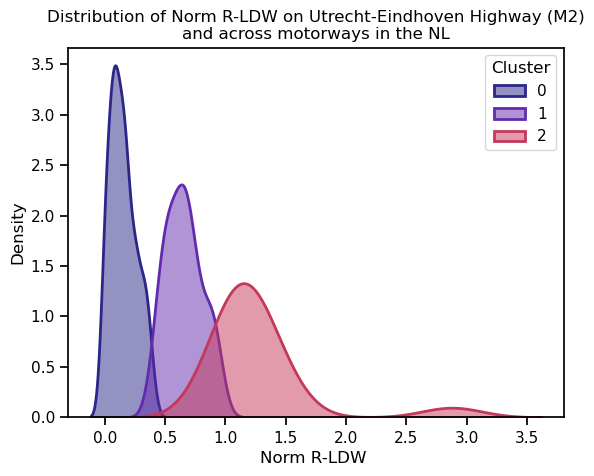

In [21]:
def viz_classes():
    sns.set_palette("CMRmap")
    sns.kdeplot(Clusters[Clusters['Clusters']==0][feature],label="0",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==1][feature],label="1",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==2][feature],label="2",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==3][feature],label="3",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==4][feature],label="4",fill=True,alpha=0.5,linewidth=2)
    sns.kdeplot(Clusters[Clusters['Clusters']==5][feature],label="5",fill=True,alpha=0.5,linewidth=2)
    plt.legend(title="Cluster")
    plt.title(r"Distribution of "+feature_name+"on "+ location+"\n"+"and "+location1)
    # plt.title(r"Distribution of "+feature_name+" in "+ city_name + "\n"+" and the NL (Urban Roads) - Clusters")
    plt.xlabel(feature_name)
    
viz_classes()

In [22]:
highway_name=Clusters['Motorway'].unique()[0]
corresponding_trips=Clusters['Motorway'].unique()[1]

df_city=Clusters.loc[Clusters['Motorway']==highway_name]
df_city = df_city.drop(df_city[df_city.Numberplate=='WPR23X'].index)
df_not_city=Clusters.loc[Clusters['Motorway']==corresponding_trips]

Text(0.5, 0, 'Cluster')

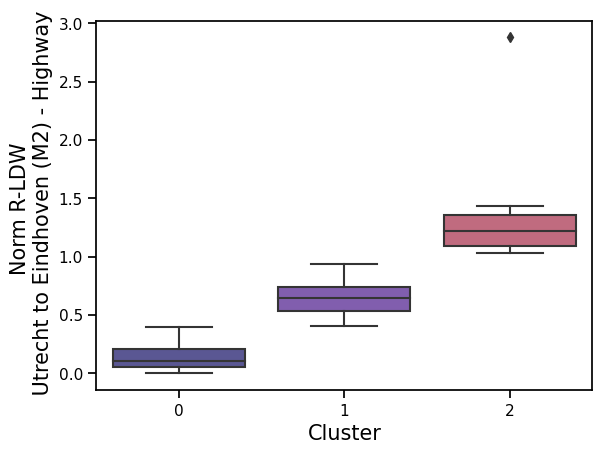

In [23]:
import matplotlib as mpl
sns.set_palette("CMRmap")
ax = sns.boxplot(x=df_city['Clusters'],y=df_city[feature],fliersize=5)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .82))

plt.ylabel(feature_name+"\n "+ highway_name +" - Highway",fontsize=15)
# plt.ylabel(feature_name)
plt.xlabel("Cluster",fontsize=15)
# plt.savefig(r"C:\Users\ivasu\Desktop\p2.png")

Text(0, 0.5, 'Density')

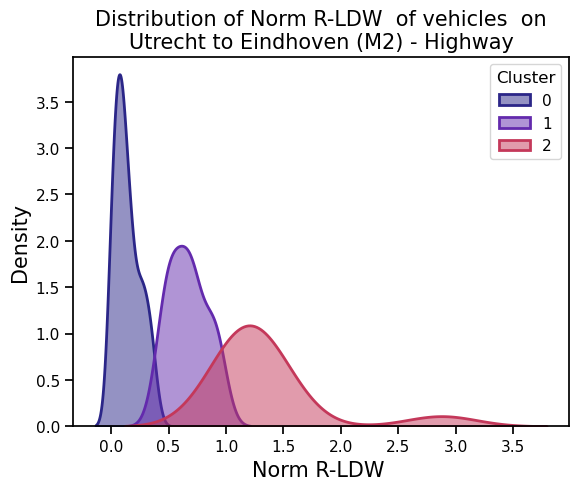

In [24]:
sns.set_palette("CMRmap")
sns.kdeplot(df_city[df_city['Clusters']==0][feature],label="0",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_city[df_city['Clusters']==1][feature],label="1",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_city[df_city['Clusters']==2][feature],label="2",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_city[df_city['Clusters']==3][feature],label="3",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_city[df_city['Clusters']==4][feature],label="4",fill=True,alpha=0.5,linewidth=2)
plt.legend(title="Cluster")
plt.title(r"Distribution of "+ feature_name+" of vehicles "+" on"+"\n"+highway_name +" - Highway",fontsize=15)
plt.xlabel(feature_name,fontsize=15)
plt.ylabel("Density",fontsize=15)
# plt.savefig(r"C:\Users\ivasu\Desktop\p5.png")

Text(0.5, 0, 'Mean Point Speed (km/h)')

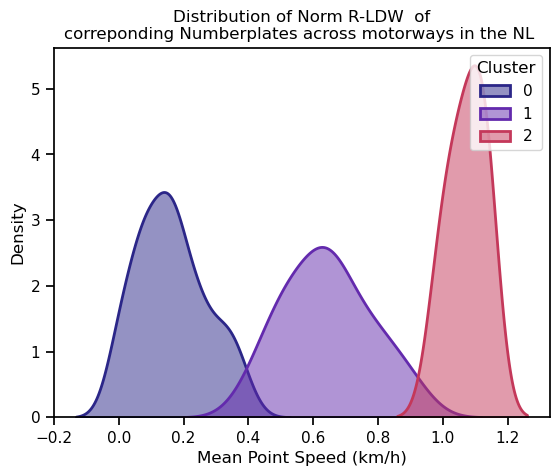

In [25]:
sns.set_palette("CMRmap")
sns.kdeplot(df_not_city[df_not_city['Clusters']==0][feature],label="0",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_not_city[df_not_city['Clusters']==1][feature],label="1",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_not_city[df_not_city['Clusters']==2][feature],label="2",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_not_city[df_not_city['Clusters']==3][feature],label="3",fill=True,alpha=0.5,linewidth=2)
sns.kdeplot(df_not_city[df_not_city['Clusters']==4][feature],label="4",fill=True,alpha=0.5,linewidth=2)
plt.legend(title="Cluster")
plt.title("Distribution of "+ feature_name+" of"+"\n"+"correponding Numberplates across motorways in the NL ")
plt.xlabel("Mean Point Speed (km/h)")

In [26]:
df_city_cluster0=df_city[df_city['Clusters']==0]
df_city_cluster0_nums=list(df_city_cluster0['Numberplate'])

df_city_cluster1=df_city[df_city['Clusters']==1]
df_city_cluster1_nums=list(df_city_cluster1['Numberplate'])

df_city_cluster2=df_city[df_city['Clusters']==2]
df_city_cluster2_nums=list(df_city_cluster2['Numberplate'])

df_city_cluster3=df_city[df_city['Clusters']==3]
df_city_cluster3_nums=list(df_city_cluster3['Numberplate'])

df_city_cluster4=df_city[df_city['Clusters']==4]
df_city_cluster4_nums=list(df_city_cluster4['Numberplate'])

df_city_cluster5=df_city[df_city['Clusters']==5]
df_city_cluster5_nums=list(df_city_cluster5['Numberplate'])

In [27]:
%%capture
df_not_city_cluster0_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster0_nums)]
df_not_city_cluster0_nums['Cluster_city']=0
df_not_city_cluster1_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster1_nums)]
df_not_city_cluster1_nums['Cluster_city']=1
df_not_city_cluster2_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster2_nums)]
df_not_city_cluster2_nums['Cluster_city']=2
df_not_city_cluster3_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster3_nums)]
df_not_city_cluster3_nums['Cluster_city']=3
df_not_city_cluster4_nums = df_not_city[df_not_city['Numberplate'].isin(df_city_cluster4_nums)]
df_not_city_cluster4_nums['Cluster_city']=4


In [28]:
list_of_dataframes=[df_not_city_cluster0_nums,df_not_city_cluster1_nums,df_not_city_cluster2_nums,df_not_city_cluster3_nums]
df_not_city_new_clus = pd.concat(list_of_dataframes)
df_not_city_new_clus

,Numberplate,Latitude,Longitude,Mean Point Speed (km/h),Distance Covered (km),Normalized Braking Events,Normalized Level I-HW,Normalized Level II-HW,Normalized Level III-HW,Normalized L-LDW,Normalized R-LDW,Motorway,Clusters,Cluster_city
0,BLFR75,51.826783,4.855629,82.968989,13521.369,0.000000,1.443271,0.348411,0.123212,0.031284,0.177127,Corresponding Trips (M2-NL),0,0
1,BLLF65,51.953271,5.202296,79.906177,4739.117,0.000000,2.138162,0.495029,0.146019,0.035028,0.152138,Corresponding Trips (M2-NL),0,0
3,BLLG74,51.985003,5.290594,82.422666,14837.784,0.000000,0.920960,0.233525,0.069957,0.110394,0.083436,Corresponding Trips (M2-NL),0,0
4,BLLG77,52.177090,5.502376,81.230589,7279.406,0.000000,1.796163,0.463774,0.178998,0.101657,0.713795,Corresponding Trips (M2-NL),1,0
5,BLLR40,51.977626,5.170556,79.795535,10255.833,0.000000,1.302381,0.212952,0.054018,0.008385,0.082490,Corresponding Trips (M2-NL),0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,BTDR89,52.032954,5.095616,79.335497,13444.373,0.438102,1.636819,0.248282,0.059728,0.030273,1.130361,Corresponding Trips (M2-NL),2,2
102,BTDS92,51.946917,5.211549,79.968079,8228.380,0.000000,1.028392,0.228478,0.069272,0.089811,0.336640,Corresponding Trips (M2-NL),0,2
130,BVFP90,52.292091,5.400226,83.337392,15638.594,0.000000,1.523219,0.355147,0.112862,0.136329,0.741883,Corresponding Trips (M2-NL),1,2
139,BVNP44,51.738762,5.392049,81.448598,5769.562,0.000000,0.270904,0.068809,0.011266,0.012653,0.255479,Corresponding Trips (M2-NL),0,2


Text(0.5, 1.0, 'Norm R-LDW  of corresponding vehicles \nbased on cluster assigned in \nUtrecht to Eindhoven (M2) - Highway')

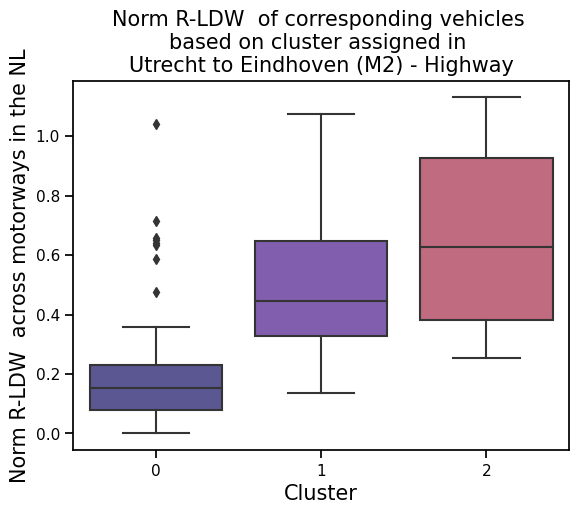

In [29]:
import matplotlib as mpl
ax = sns.boxplot(x=df_not_city_new_clus['Cluster_city'],y=df_not_city_new_clus[feature],fliersize=5)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .82))
    
plt.ylabel(feature_name+" across motorways in the NL",fontsize=15)
plt.xlabel("Cluster",fontsize=15)
plt.title(feature_name+ " of corresponding vehicles "+"\n"+"based on cluster assigned in "+"\n"+highway_name +" - Highway",fontsize=15)
# plt.ylim(-0.1,1.4)
# plt.savefig(r"C:\Users\ivasu\Desktop\p3.png")

In [30]:
df_outer = pd.merge(df_city, df_not_city, on='Numberplate', how='inner') #here Numberplate is common column
df_outer['cluster_comp'] = np.where(df_outer['Clusters_x']==df_outer['Clusters_y'], 'True', 'False')

In [31]:
a=df_outer[df_outer['cluster_comp']=='True']
# a['clusters_utrecht'].value_counts()
len(df_outer[df_outer['cluster_comp']=='True'])/len(df_outer)*100

75.89285714285714

In [32]:
df_outer_true=df_outer[df_outer['cluster_comp']=="True"]
df_outer_true['Clusters_y'].value_counts()/len(df_outer_true)*100

0    83.529412
1    12.941176
2     3.529412
Name: Clusters_y, dtype: float64

In [33]:
location="_x"
location1="_y"

Text(0.5, 1.0, 'Norm R-LDW of vehicles and their corresponding clusters')

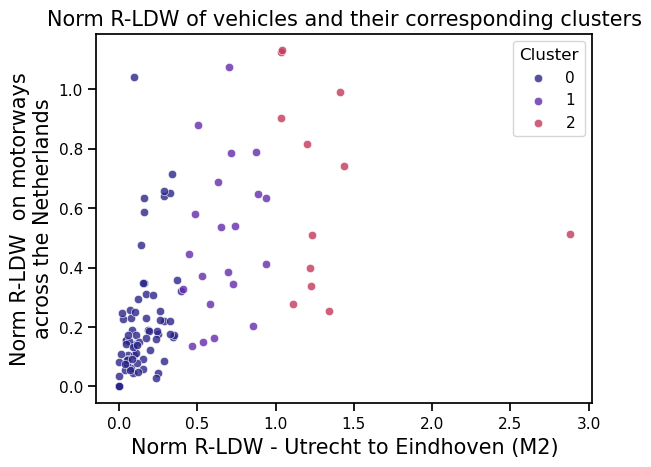

In [34]:
sns.set_palette("CMRmap")
sns.set_context("notebook")
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==0],x=feature+location,y=feature+location1,alpha=0.8,label=0)
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==1],x=feature+location,y=feature+location1,alpha=0.8,label=1)
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==2],x=feature+location,y=feature+location1,alpha=0.8,label=2)
sns.scatterplot(data=df_outer[df_outer['Clusters_x']==3],x=feature+location,y=feature+location1,alpha=0.8,label=3)
plt.legend(title="Cluster")

plt.xlabel(feature_name+"- "+highway_name,fontsize=15)
plt.ylabel(feature_name+" on motorways"+"\n"+"across the Netherlands",fontsize=15)
plt.title(feature_name+ "of vehicles "+"and their corresponding clusters",fontsize=15)
# plt.savefig(r"C:\Users\ivasu\Desktop\p4.png")